# EO AI Coding Challenge
Demonstrate a standard end-to-end pipeline for field instance segmentation. 
Train a quick deep learning baseline model, which, if trained properly, would delineate boundaries for each individual field.

Please perform the following tasks and submit the executed notebook back to us. 

## Dataset
* The **predictor** data set consists of PCA-transformed Sentinel 2 NDVI time-series. Only the first 5 principal components are provided.  

* The **response** consists of a geopackage of field outlines (polygons).

## Minimum steps
* build a training and validation dataset (tiling and label generation)
* set up a standard training loop (framework of your choice)
* train a baseline model of your choice (finetune pretrained architecture or train from scratch)
* display loss curve
* display whichever error metrics you'd consider important
* run the model in inference mode on a single validation batch and plot the predicted boundaries on top of the corresponding predictors
* describe in text form which further considerations and steps you would take to improve the model, if you were working on it for real.

## Considerations
* Make sure the code is deterministic and reproducible (set seeds and report module versions)
* Feel free to display plots you'd normally use during development
* No need to invest much effort into optimization, e.g. parallel implementations.
It is sufficient to run for few epochs and even on CPU. Results will *not* be judged based on model performance!

## Assessment
 Evaluation will be based on:
* appropriateness of steps taken to accomplish the task
* clarity and quality of the code 
* suggestions for model improvement

## Overview
A VGG style Unet is used to perform segmentation of field boundaries on the first three bands of the PCA Sentinel 2 time series data. OpenCV's connected components with stat function was used to give each field a separate ID.

## To run
`docker build -t eoai_task .`

`docker run -p 8888:8888 -v local_path_to_tlg_eoai_task_results_folder:/app/notebooks -v local_path_to_tlg_eoai_task_results_folder/data:/app/data eoai_test`

go to `http://localhost:8888` to access the notebook.


The workflow consisted of the following steps.
* Pre-processing the training image
    * Select the necessary bands;
    * Perform a percentile clip;
    * Normalize the image value between 0 and 1 as required for training.
* Pre-process the label data
    * Apply a negative buffer of 5 meter
    * Rasterize the buffered vector data;
    * Create a weight layer for the labels;
    * Merge the label and weight layer by stacking the former on top of the latter.
* Create the training and validation dataset
    * Tile the image and label data. A 25% overlap is applied to slightly increase the amount of training.
    * Apply 90, 180, 270 degree rotations to the dataset;
    * Randomly split the training (75%) and validation (25%) data.
* Train a model
* Run a prediction on a validation tile

### Pre-processing
The data available consisted of a five band PCA Sentinel 2 NDVI time-series, and a Geopackage with vectors representing crop fields. Only the first three bands of the PCA data are used, since there are significant artifacts in bands four and five, which could influence the overall model accuracy. Band three also has some artifacts in the middle at the top. However, band three aided with making the fields more distinguishable which outweighed the effects of the artifacts. A percentile clip with values 2 and 98 was applied to the image to remove outlier values and increase the contrast and brightness in the image. Normalizing an image between 0 and 1 before training improves model performance and training efficiency.
There were some missing fields in the vector data set but were left as is. It also seems that the vector data was captured on a higher resolution image, since it was not always possible to identify some of the thinner and smaller fields on the image. A negative 5 meter buffer is applied to the vector data in order for the model to better segment individual fields. This step also removed the majority of the smaller fields which were not visible on the training image. Five meters was selected since it is half the resolution of the raster data and fields close to each other should at least have a one pixel border between them.
A weight layer was created for the labels to force the model to prioritize segmenting boundaries of fields located close together. Using a weight layer with the labels when training a U-Net is a technique to enhance the model's focus on specific regions of interest during the segmentation task. By assigning different weights to pixels in the ground truth masks, the network's learning process is guided towards accurately segmenting important or challenging regions. This can result in improved performance, particularly in scenarios where certain classes or regions are underrepresented or require special attention. The weight layer can also be calculated during training with the data generator but it significantly slows down training.
Finally the labels and weight layer are merged by stacking the former on top of the latter.

### Training data set creation
The available data is fairly limited, only 1049 by 735 pixels. In order to maximize the amount of training data patch size is set to 256 by 256 pixels, to maintain some context of larger features, an overlap of 25% is applied, and each data tile is rotated three times at 90, 180, and 270 degrees.
Just rotating the data, essentially duplicating the data, can seem illogical at first and strongly hint at overfitting. However, this step has proved valuable for small datasets since it increases the amount of data in the dataset allowing the model to train on more data per epoch. As the training dataset grows and the overall quality increases, rotating the dataset is no longer required. In contrast to traditional data augmentation, where the amount of training data does not increase but rather aids with training a more generalized model.
The data was split 75% training data and 25% validation data. In the end there are 72 tiles in the training data set and 24 tiles in the validation dataset.

### Model training
A vgg style Unet is used, since it is fairly basic and easy to work with and generally gives good results. Filter size starts at 64 and stops at 512. Batch size is set to 1 due to the small training dataset, which updates the model weights every time an image passes through the model. This is at the expense of a model which generalizes well. A custom keras data generator is used as it allows for more flexibility when using remote sensing data while maintaining the built-in multithreaded and multiprocessed speed improvements.
Only validation loss and validation accuracy is used to get an idea of how the model performs. Intersection-over-union is also a common metric to use, however, it is really only useful if the label data fit the image data very well, which is not the case here.

Note: The model training is stochastic by nature and results may vary after every run. However, the final validation accuracy is generally around 81% to 86%.

### Model inference and post-processing
The model is used to predict field boundaries on one of the validation tiles. A threshold is applied to the probabilities to separate fields from the non-fields. Opencv's connected components with stats function is used to separate the fields and assign each field an ID.
Watershed algorithm or grabcut algorithm with the results from deep learning can be used as a post-processing step to further improve the results and segment fields with less obvious contrast that was missed by the deep learning model.

### Model improvements
Some of the potential ways to improve model performance are:
* Clean the data. Make sure the labels correspond with the image and that artifacts are kept to a minimum;
* Get more training data;
* Use higher resolution imagery (planet perhaps);
* Use a different, more complex, deep learning architecture such as mask RCNN;
* Use more advanced post-processing methods such as watershed or grabcut segmentation;
* Apply augmentation to aid model generalization.




### Initial imports, definitions and parameters

In [57]:
# Imports
import os
import random
import shutil
from copy import deepcopy

import numpy as np
from osgeo import gdal
from osgeo import ogr
import cv2
import matplotlib.pyplot as plt

from unet_weight_map import UnetWeightMap
from data_generator import DataGenerator


In [58]:
# Define functions used often
def write_geotiff(filename, data, geo_transform, projection):
    """
    Write a GeoTIFF file using given data, geotransform, and projection information.

    Parameters
    ----------
    filename : str
        Path to the output GeoTIFF file.
    data : numpy.ndarray
        Data array to be written as a GeoTIFF.
    geo_transform : tuple
        Geotransformation coefficients for the GeoTIFF.
    projection : str
        Projection information in WKT format.
    """
    driver = gdal.GetDriverByName('GTiff')
    try:
        n, rows, cols = data.shape
    except:
        n = 1
        rows, cols = data.shape
        
    opt = ['COMPRESS=DEFLATE',
           'PREDICTOR=2',
           'ZLEVEL=6',
           'NUM_THREADS=6',
           'TILED=YES',
           'BLOCKXSIZE=256',
           'BLOCKYSIZE=256']
    
    dataset = driver.Create(filename, cols, rows, n, gdal.GDT_Float32, options=opt)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
                    
    for d in range(1,n+1):
        band = dataset.GetRasterBand(d)
        if n == 1:
            band.WriteArray(data)
        else:
            band.WriteArray(data[d-1])
    dataset = None


def read_raster(path):
    """
    Read a raster image and return its array, projection, and geotransformation.

    Parameters
    ----------
    path : str
        Path to the input raster image.

    Returns
    -------
    tuple
        Tuple containing image array, projection, and geotransformation.
    """
    ds = gdal.Open(path)
    prj = ds.GetProjectionRef()
    gt = ds.GetGeoTransform()
    image_array = ds.ReadAsArray()
    ds = None

    return image_array, prj, gt

In [59]:
# Define the input and output directories and files
# Label data info
vector_labels = r"/app/notebooks/data/eoai_response_fieldboundaries.gpkg"
vector_labels_buffered = r"/app/notebooks/data/buffered.gpkg"
buffered_layer_name = r"buffered"
raster_label = r"/app/notebooks/data/labels.tif"

# Raster data
image_filename = r"/app/notebooks/data/eoai_preds_pca.tif"

# Results folder
results_folder = r"/app/notebooks/data"
print(os.listdir(results_folder))

# Training data
image_folder = os.path.join(results_folder, "image")
label_folder = os.path.join(results_folder, "label")
validation_img_folder = os.path.join(results_folder, "validation", "image")
validation_lbl_folder = os.path.join(results_folder, "validation", "label")

# Model path and filename
model_path = os.path.join(results_folder, "field_boundaries.h5")

# Parameters
buffer_distance = -5
epsg_code = 32633
prefix = "field_boundaries"

['buffered.gpkg', 'eoai_preds_pca.tif', 'eoai_response_fieldboundaries.gpkg', 'field_boundaries.h5', 'field_boundaries_log.csv', 'image', 'label', 'labels.tif', 'validation']


# Pre-processing

## Pre-process image data

In [60]:
# Read image data
image_array, projection, geotransform = read_raster(image_filename)
# Select only the first 3 bands of the input image.
image_array = image_array[:3]
channels, image_y_size, image_x_size = image_array.shape
print("Image array dimensions", channels, image_y_size, image_x_size)

Image array dimensions 3 735 1049


In [61]:
# Define percentile clip and normalize functions
def percentile_clip(band_array, lower_value=2, upper_value=98):
    """
    Clip values in the array based on percentiles.

    Parameters
    ----------
    band_array : numpy.ndarray
        Input array to be clipped.
    lower_value : float, optional
        Lower percentile value for clipping. Default is 2.
    upper_value : float, optional
        Upper percentile value for clipping. Default is 98.

    Returns
    -------
    numpy.ndarray
        Clipped array.
    """
    # Shift the array to be non-negative
    band_array = band_array + np.abs(np.min(band_array))
    # Calculate lower and upper percentiles
    p_low, p_high = np.percentile(band_array, [lower_value, upper_value])
    print("lower and upper percentiles", p_low, p_high)

    return np.clip(band_array, p_low, p_high)


def normalize_to_zero_and_one(array):
    """
    Normalize the array values to the range [0, 1].

    Parameters
    ----------
    array : numpy.ndarray
        Input array to be normalized.

    Returns
    -------
    numpy.ndarray
        Normalized array with values in the range [0, 1].
    """
    
    # Normalize the array using OpenCV's normalize function
    return cv2.normalize(array, None, 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [62]:
# Pre-process image
# Percentile clip image to remove outliers
image_array_percentile_clipped = np.stack([percentile_clip(image_array[n]) for n in range(channels)], axis=0)
print("Percentile clipped array shape", image_array_percentile_clipped.shape)

# Normalize the array values between 0 and 1 (DL model requires the data to be between 0 and 1).
image_array_norm = np.stack([normalize_to_zero_and_one(image_array_percentile_clipped[n]) for n in range(channels)], axis=0)
print("Normalized array shape", image_array_norm.shape)

# Clamp minimum value to 0.0
image_array_norm[image_array_norm < 0] = 0.0
image_array_norm[image_array_norm > 1] = 1.0
print("Normailized array min, max", np.min(image_array_norm), np.max(image_array_norm))

lower and upper percentiles 0.1991316342564695 3.231370900336791
lower and upper percentiles 0.27935793337594833 3.5420289376738516
lower and upper percentiles 0.5496296586566959 1.8790929299453365
Percentile clipped array shape (3, 735, 1049)
Normalized array shape (3, 735, 1049)
Normailized array min, max 0.0 1.0


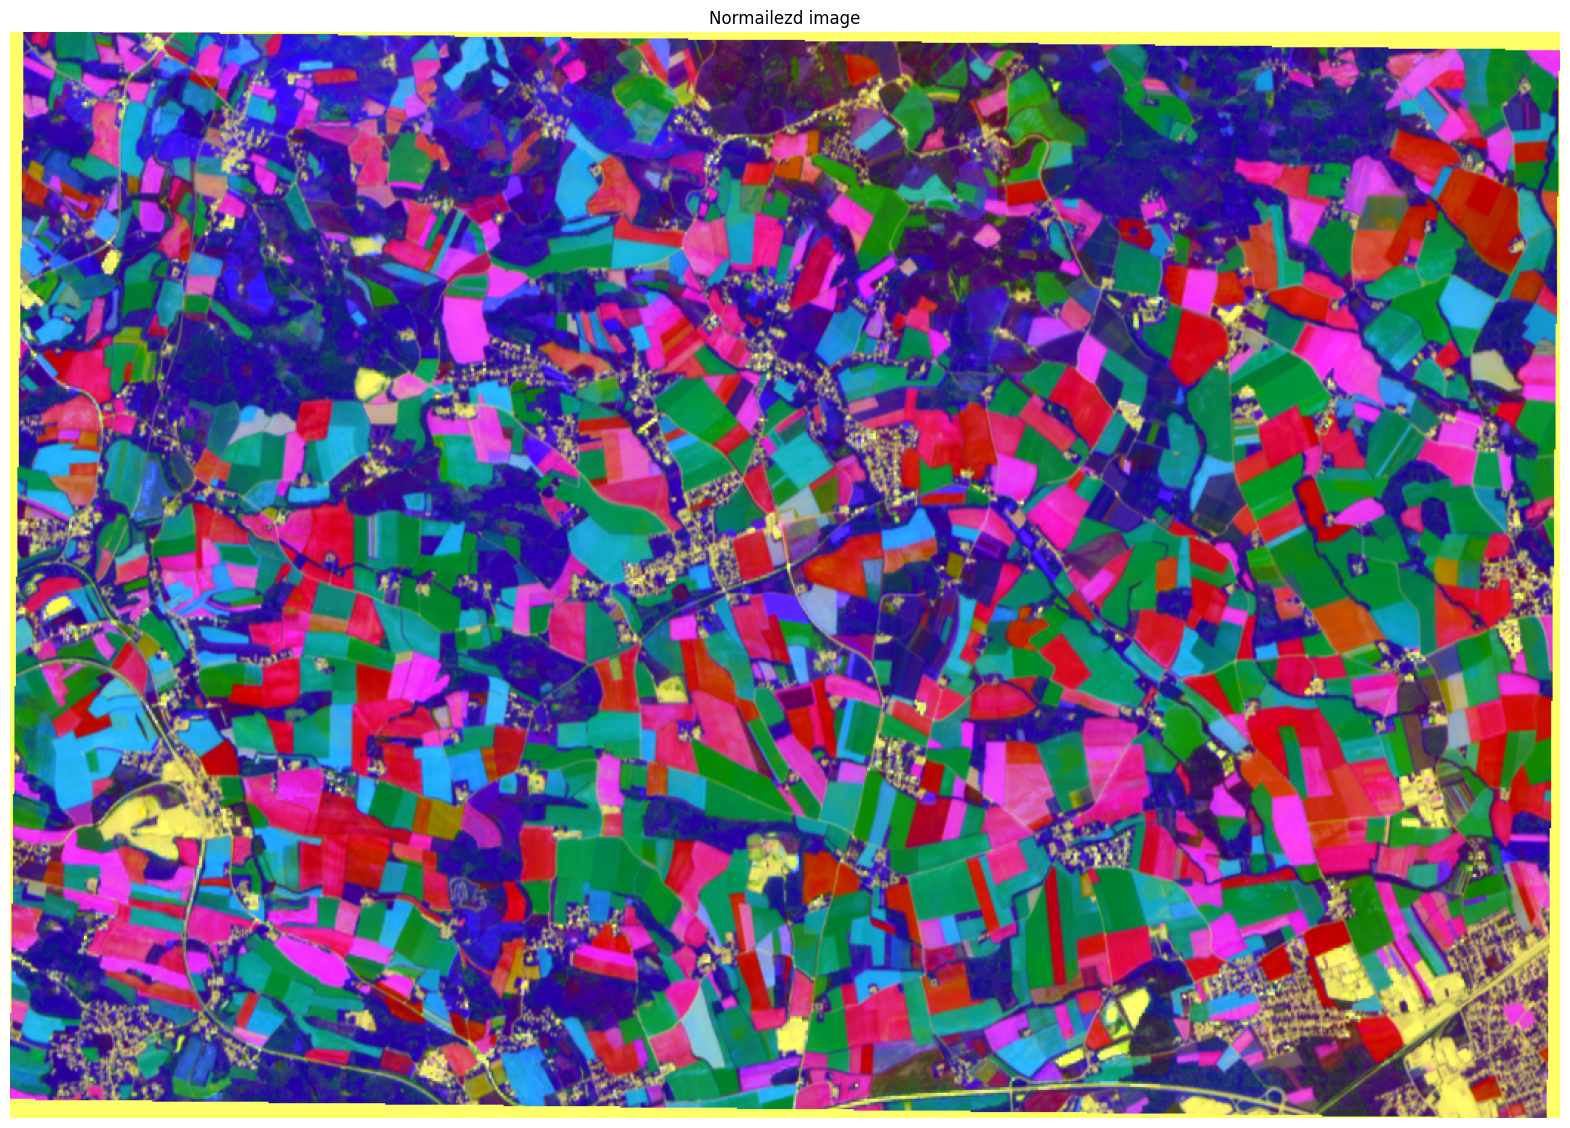

In [63]:
# Display normaized array
plt.figure(figsize = (20, 20))
plt.title("Normailezd image")
plt.imshow(np.transpose(image_array_norm, (1, 2, 0)))
plt.axis('off') 
plt.show()


## Pre-process labels

In [64]:
# Define buffer function
def apply_buffer(src_file, dst_file, layer_name, buffer_distance):
    """
    Apply a buffer to the geometries in a vector layer and save to a new file.

    Parameters
    ----------
    src_file : str
        Path to the source vector file.
    dst_file : str
        Path to the destination vector file where buffered features will be saved.
    layer_name : str
        Name of the new layer to be created in the destination file.
    buffer_distance : float
        Buffer distance to apply to the features.

    Returns
    -------
    None
    """
    # Open the source vector file and layer
    input_ds = ogr.Open(src_file)
    input_layer = input_ds.GetLayer()
    input_CRS = input_layer.GetSpatialRef()

    # Get a driver for the destination vector format (GeoPackage in this case)
    vec_driver = ogr.GetDriverByName('GPKG')

    # Delete the destination file if it already exists
    if os.path.exists(dst_file):
        vec_driver.DeleteDataSource(dst_file)

    # Create a new destination vector file and layer
    dst_buffer = vec_driver.CreateDataSource(dst_file)
    buffer_layer = dst_buffer.CreateLayer(layer_name, geom_type=ogr.wkbPolygon, srs=input_CRS)
    feature_defination = buffer_layer.GetLayerDefn()
    
    # Iterate through the features in the input layer
    for feature in input_layer:
        src_geom = feature.GetGeometryRef()
        # Apply buffer to the geometry
        geom_buffer = src_geom.Buffer(buffer_distance)
        
        # Create a new feature with the buffered geometry and add it to the destination layer
        dsc_Feature = ogr.Feature(feature_defination)
        dsc_Feature.SetGeometry(geom_buffer)
        buffer_layer.CreateFeature(dsc_Feature)
        dsc_Feature = None

# Clean up and close data sources
input_ds = None

In [65]:
# Apply a neg 5m buffer
apply_buffer(vector_labels, vector_labels_buffered, buffered_layer_name, buffer_distance)

Warning 1: A geometry of type MULTIPOLYGON is inserted into layer buffered of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


In [66]:
# Define rasterize function
def vector2raster(src_vector_name, dst_raster_name, srid, geotransform, dst_x_size, dst_y_size):
    """
    Convert a vector layer to a raster image.

    Parameters
    ----------
    src_vector_name : str
        Path to the source vector layer.
    dst_raster_name : str
        Path to the output raster image.
    srid : int
        Spatial Reference ID (EPSG code) of the data.
    geotransform : tuple
        Geotransformation parameters for the output raster.
    dst_x_size : int
        Width of the output raster in pixels.
    dst_y_size : int
        Height of the output raster in pixels.

    Returns
    -------
    numpy.ndarray
        Array representation of the converted raster image.
    """
    ulx, res_x, rotx, uly, roty, res_y = geotransform
    llx = ulx + (dst_x_size * abs(res_x))
    lly = uly - (dst_y_size * abs(res_y))
    
    # Rasterize the vector layer
    gdal.Rasterize(dst_raster_name, src_vector_name,
                   outputType=gdal.GDT_Byte,
                   outputSRS=f'EPSG:{srid}',
                   width=dst_x_size, height=dst_y_size,
                   outputBounds=[ulx, lly, llx, uly],
                   initValues=0,
                   burnValues=255,
                   allTouched=False)
    
    # Open the generated raster and read its array
    shapeRasDS = gdal.Open(dst_raster_name)
    src_array = shapeRasDS.ReadAsArray()
    shapeRasDS = None
    
    return src_array

In [67]:

# Rasterize the buffered vectors
label_array = vector2raster(vector_labels_buffered, raster_label, epsg_code, geotransform, image_x_size, image_y_size)

Label minimum and maximum values: 0 255


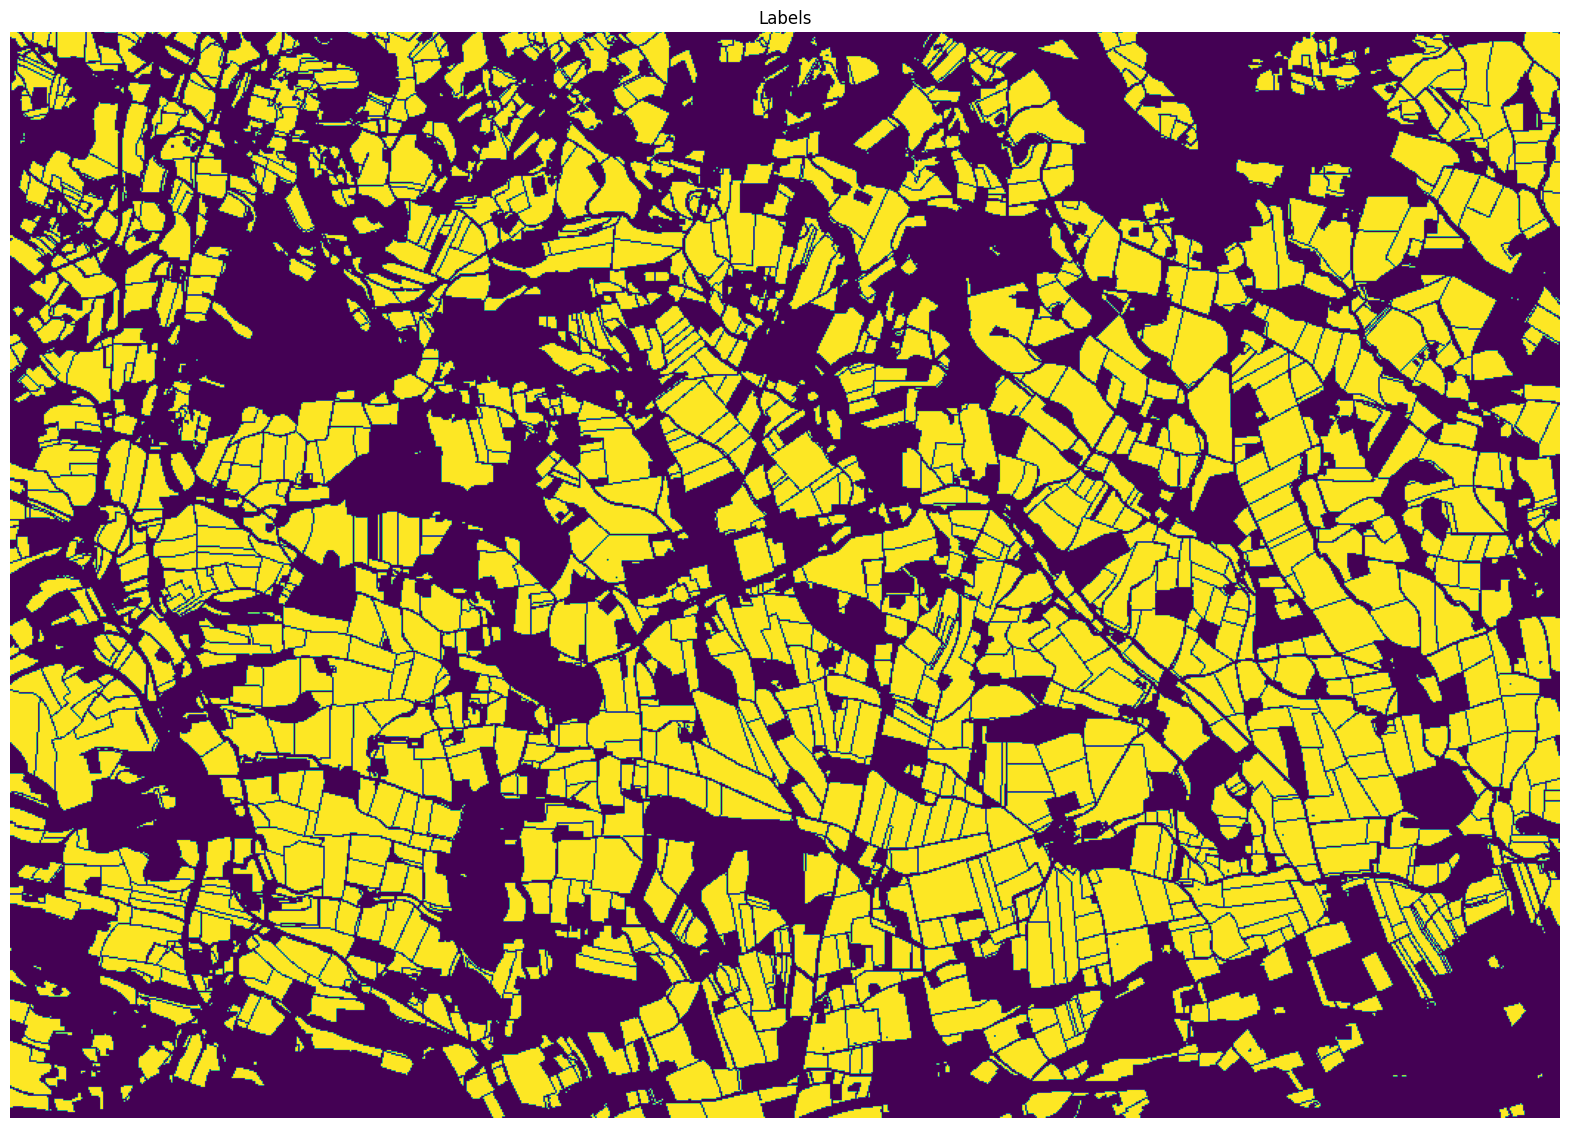

In [68]:
# Show Rasterized labels
print("Label minimum and maximum values:", np.min(label_array), np.max(label_array))
plt.figure(figsize = (20, 20))
plt.title("Labels")
plt.imshow(label_array)
plt.axis('off') 
plt.show()

## Weight layer


In [69]:
# Create the weight layer (Takes a minute or two to run)

class_weights = {0: 1, 1: 5}  # class weight dictionary
w0 = 10  # Border weight
sigma = 5  # Border width

# Ensure labels are seperated to improve distance calculation
kernel = np.ones((2, 2), np.uint8)
weight_array = cv2.erode(label_array, kernel)
weight_array = weight_array.astype(np.float32) / 255

# Create the weight layer
weight_array = UnetWeightMap(weight_array, class_weights).weight_map()
weight_array[label_array == 255] = 5

1.0 9.899691


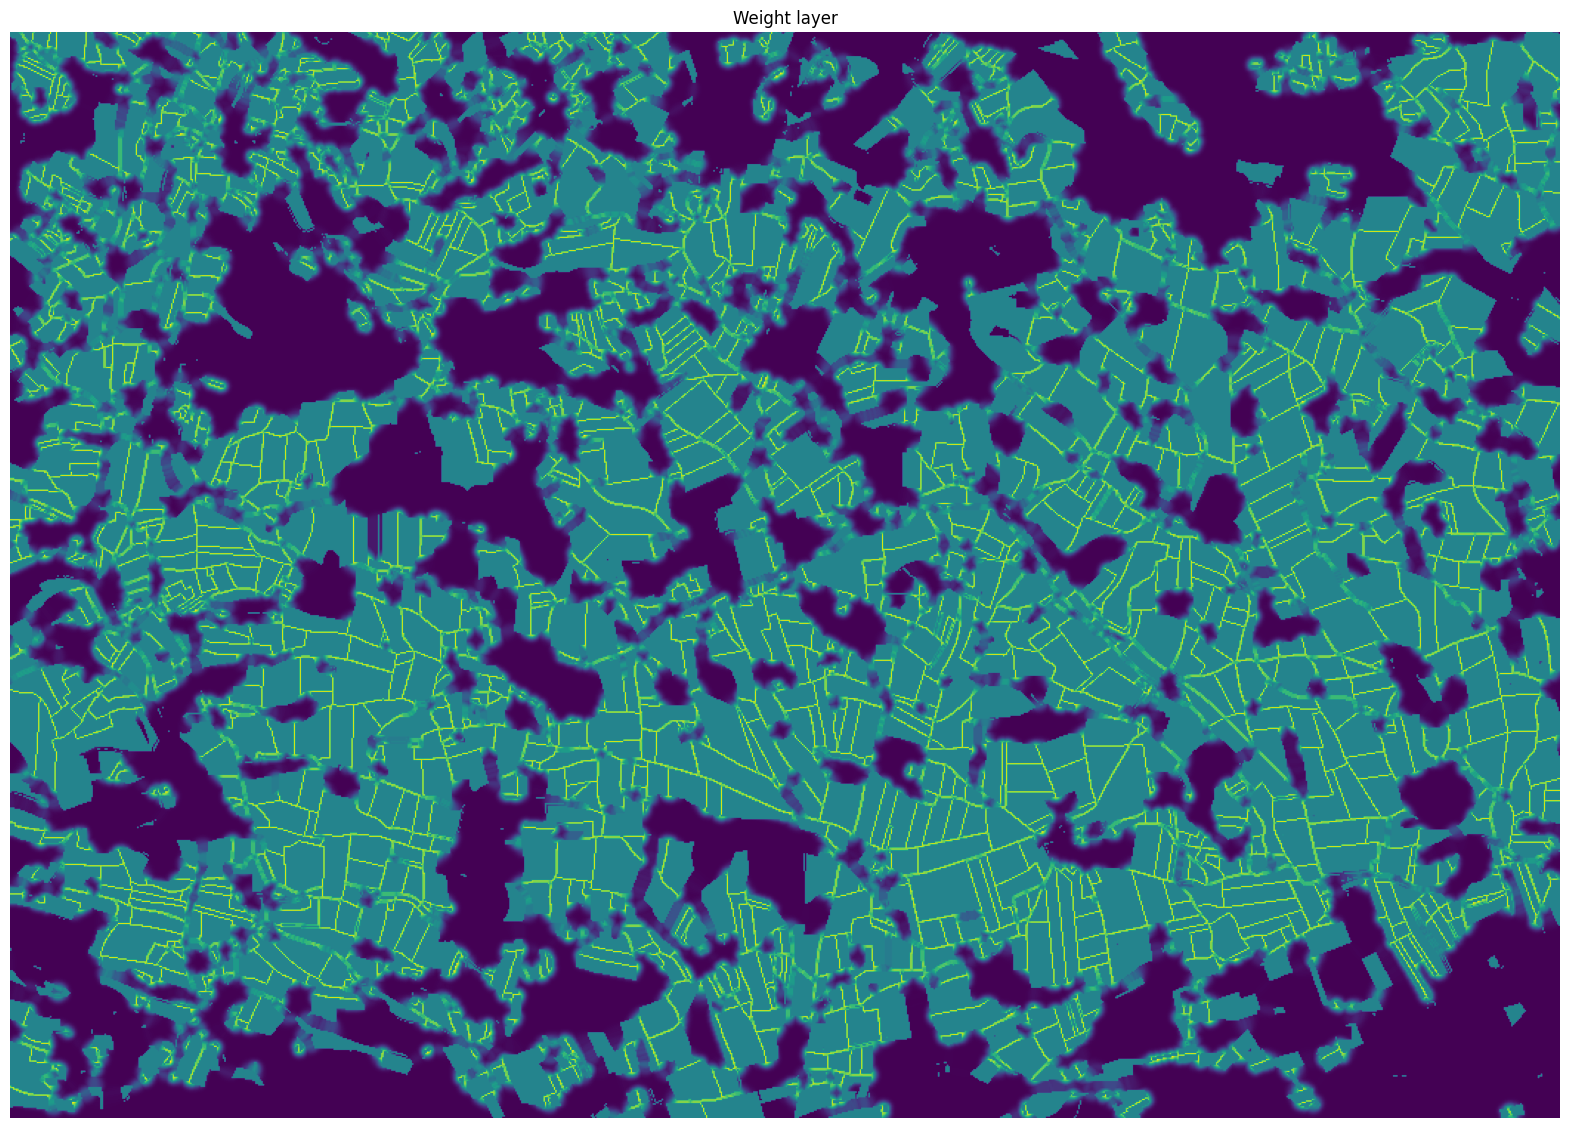

In [70]:
# Display weight layer
print(np.min(weight_array), np.max(weight_array))
plt.figure(figsize = (20, 20))
plt.title("Weight layer")
plt.imshow(weight_array)
plt.axis('off') 
plt.show()

In [71]:
# Merge the label data and weights layer
# The first layer is the labels and the second layer the weight layer
labels_array = np.stack([label_array, weight_array], axis=0).astype(np.float32)

print("labels_array shape", labels_array.shape)

labels_array shape (2, 735, 1049)


# Training dataset

In [72]:
# Remove and create folder structure
folder_list = [image_folder, label_folder, validation_img_folder, validation_lbl_folder]

for folder in folder_list:
    # Remove folder if it already exist"
    if os.path.exists(folder):
        shutil.rmtree(folder)
    # Create the folder
    os.makedirs(folder)

print("Data folders", os.listdir(results_folder))


Data folders ['buffered.gpkg', 'eoai_preds_pca.tif', 'eoai_response_fieldboundaries.gpkg', 'field_boundaries.h5', 'field_boundaries_log.csv', 'image', 'label', 'labels.tif', 'validation']


## Tile the data

In [73]:
# Create the dataset
# Create tiled training data
def create_block(array, output_filename, prefix, dst_x_size, dst_y_size, geotransform, projection, patch_size=256, minVal=50):
    """
    Create and save patches (blocks) from an input array as separate GeoTIFF files.

    Parameters
    ----------
    array : numpy.ndarray
        Input data array.
    output_filename : str
        Path to the output directory where blocks will be saved.
    prefix : str
        Prefix for the generated block filenames.
    dst_x_size : int
        Width of the entire output area in pixels.
    dst_y_size : int
        Height of the entire output area in pixels.
    geotransform : tuple
        Geotransformation parameters for the output blocks.
    projection : str
        Projection information in WKT format.
    patch_size : int, optional
        Size of the patch (block) in pixels. Default is 256.
    minVal : int, optional
        Minimum overlap value between patches. Default is 50.

    Returns
    -------
    list
        List of generated block filenames.
    """
    file_list = []
    ulx, x_res, xskew, uly, yskew, y_res  = geotransform

    # Tile the array with overlap    
    for i in range(0, dst_y_size, (patch_size - minVal)):
        if i + patch_size <= dst_y_size:
            rows = patch_size
            rOverlap = minVal
        else:
            rows = patch_size
            rOverlap = patch_size - (dst_y_size - i)

        for j in range(0, dst_x_size, (patch_size - minVal)):
            if j + patch_size <= dst_x_size:
                cols = patch_size
                cOverlap = minVal
            else:
                cols = patch_size
                cOverlap = patch_size - (dst_x_size - j)
            
            # Define a subset of the array based on patch coordinates and
            # compute the geotransformation for the current patch
            if (j == 0) and (i == 0):
                data = array[:, i: i + rows, j: j + cols]
                geotransform = []
                geotransform.append(ulx + (j * x_res))
                geotransform.append(x_res)
                geotransform.append(0.0)
                geotransform.append(uly + (i * y_res))
                geotransform.append(0.0)
                geotransform.append(y_res)
                
            elif j == 0:
                data = array[:, (i - rOverlap): (i - rOverlap) + rows, j: j + cols]
                geotransform = []
                geotransform.append(ulx + (j * x_res))
                geotransform.append(x_res)
                geotransform.append(0.0)
                geotransform.append(uly + ((i - rOverlap) * y_res))
                geotransform.append(0.0)
                geotransform.append(y_res)
                
            elif i == 0:
                data = array[:, i: i + rows, (j - cOverlap): (j - cOverlap) + cols]
                geotransform = []
                geotransform.append(ulx + ((j - cOverlap) * x_res))
                geotransform.append(x_res)
                geotransform.append(0.0)
                geotransform.append(uly + (i * y_res))
                geotransform.append(0.0)
                geotransform.append(y_res)
                
            else:
                data = array[:, (i - rOverlap): (i - rOverlap) + rows, (j - cOverlap): (j - cOverlap) + cols]
                geotransform = []
                geotransform.append(ulx + ((j - cOverlap) * x_res))
                geotransform.append(x_res)
                geotransform.append(0.0)
                geotransform.append(uly + ((i - rOverlap) * y_res))
                geotransform.append(0.0)
                geotransform.append(y_res)

            # Assign a filename for the current patch    
            tiled_filename = f"{output_filename}/{prefix}_{str(i)}_{str(j)}.tif"
            # Write the patch as a GeoTIFF file
            write_geotiff(tiled_filename, data, geotransform, projection)
            file_list.append(tiled_filename)
            data = None

    return file_list

In [74]:
# Create the dataset
# Tile the image and label/weights layer

image_list = create_block(image_array_norm, image_folder, prefix, image_x_size, image_y_size, geotransform, projection, patch_size=256, minVal=50)
label_list = create_block(labels_array, label_folder, prefix, image_x_size, image_y_size, geotransform, projection, patch_size=256, minVal=50)

print("Training image count:", len(image_list))
print("Training label count:", len(label_list))

Training image count: 24
Training label count: 24


## Data rotation

In [75]:
# Define rotation function
def rotate_training_data(image_directory, label_directory):
    """
    Rotate training images and labels and save the rotated versions.

    Parameters
    ----------
    image_directory : str
        Path to the directory containing input images.
    label_directory : str
        Path to the directory containing corresponding labels.

    Returns
    -------
    None
    """
    directory_list = [image_directory, label_directory]
    for directory in directory_list:
        # Get a list of image files in the directory
        file_list = [i for i in os.listdir(directory) 
                    if (i.endswith(".tif") and 
                    not (i.endswith(("_1.tif", "_2.tif", "_3.tif"))))
                    ]
        for image_file in file_list:
            # Open the source image
            input_file = os.path.join(directory, image_file)
            output_file = os.path.join(directory, image_file[:-4])
            src_img = gdal.Open(input_file)
            image_array = src_img.ReadAsArray()
            geo_transform = src_img.GetGeoTransform()
            proj = src_img.GetProjectionRef()
            src_img = None
            try:
                n, r, c = image_array.shape
            except:
                r, c = image_array.shape
                n = 1
            # Loop through rotation angles (0, 90, 180, 270)
            for d in range(1, 4):
                array_list = []
                for i in range(0, n):
                    if not n==1:
                        im = np.rot90(image_array[i], k=d)
                    else:
                        im = np.rot90(image_array, k=d)
                    array_list.append(im)
                    
                stacked_array = np.stack(array_list)
                # Remove existing rotated file if present
                if os.path.exists(f"{output_file}_{str(d)}.tif"):
                    os.remove(f"{output_file}_{str(d)}.tif")
                # Write the rotated image as a GeoTIFF file
                write_geotiff(f"{output_file}_{str(d)}.tif", stacked_array, geo_transform, proj)

In [76]:
# Apply rotation to the dataset
rotate_training_data(image_folder, label_folder)

print("Training image count:", len(os.listdir(image_folder)))
print("Training label count:", len(os.listdir(label_folder)))

Training image count: 96
Training label count: 96


## Split training and validation data

In [77]:
# Define validation data split function
def split_training_validation(image_train_directory,
                              label_train_directory,
                              image_validation_directory,
                              label_validation_directory,
                              extention=".tif",
                              seed_value=777):
    """
    Split training data into training and validation sets based on a given ratio.

    Parameters
    ----------
    image_train_directory : str
        Path to the directory containing training images.
    label_train_directory : str
        Path to the directory containing corresponding training labels.
    image_validation_directory : str
        Path to the directory where validation images will be saved.
    label_validation_directory : str
        Path to the directory where validation labels will be saved.
    extention : str, optional
        File extension of the image and label files. Default is ".tif".
    seed_value : int, optional
        Seed value for random number generator. Default is 777.

    Returns
    -------
    None
    """
    # Get a list of image files in the training image directory
    image_list = [i for i in os.listdir(image_train_directory)
                  if i.endswith(extention)]

    image_count = len(image_list)
    # Set the seed for randomization
    random.seed(seed_value)
    # Determine the number of images to move to validation set
    validation_count = int(image_count / 4)
    # Randomly select images for validation
    selected_indices = random.sample(range(int(image_count)), validation_count)

    for n, i in enumerate(selected_indices):
        val_img = os.path.join(image_validation_directory, image_list[i])
        val_lbl = os.path.join(label_validation_directory, image_list[i])
        img = os.path.join(image_train_directory, image_list[i])
        lbl = os.path.join(label_train_directory, image_list[i])
        # Move image and label files to validation directories
        shutil.move(img, val_img)
        shutil.move(lbl, val_lbl)
        
        if n == int(image_count / 4):
            break


In [78]:
# Splt train and validation (75/25)
split_training_validation(image_folder,
                          label_folder,
                          validation_img_folder,
                          validation_lbl_folder)

print("Training image count:", len(os.listdir(image_folder)))
print("Training label count:", len(os.listdir(label_folder)))
print("Validation image count:", len(os.listdir(validation_img_folder)))
print("Validation label count:", len(os.listdir(validation_lbl_folder)))

Training image count: 72
Training label count: 72
Validation image count: 24
Validation label count: 24


# Model Training

In [79]:
# Import tensorflow libries
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.losses import binary_crossentropy



In [80]:
# Define the function required for training
def get_steps(image_id_list, batch_size):
    """
    Calculate the number of steps per epoch based on the dataset size and batch size.

    Parameters
    ----------
    image_id_list : list
        List of image IDs or filenames in the dataset.
    batch_size : int
        Batch size for training.

    Returns
    -------
    int
        Number of steps per epoch.
    """
    epoch_steps = int(len(image_id_list) / batch_size)

    return epoch_steps


def custom_datagen(img_dir, lbl_dir, image_id_list, batch_size,
                   img_size, imgBands, n_classes, lbl_scale_list):
    """
    Create a custom data generator using the provided parameters.

    Parameters
    ----------
    img_dir : str
        Path to the directory containing images.
    lbl_dir : str
        Path to the directory containing labels.
    image_id_list : list
        List of image IDs or filenames in the dataset.
    batch_size : int
        Batch size for training.
    img_size : tuple
        Tuple representing the image dimensions (rows, columns).
    imgBands : int
        Number of image bands.
    n_classes : int
        Number of classes.
    lbl_scale_list : list
        List of label scaling factors.

    Returns
    -------
    DataGenerator
        Custom data generator.
    """    
    datagen = DataGenerator(img_dir, lbl_dir, image_id_list, batch_size=batch_size,
                            img_size=img_size, n_channels=imgBands, n_classes=n_classes,
                            shuffle=True, lbl_scale=lbl_scale_list, weight_layer=True)

    return datagen


def get_unet(img_rows, img_cols, imgBands, bn):
    """
    Create and compile a U-Net model.

    Parameters
    ----------
    img_rows : int
        Number of rows in the input image.
    img_cols : int
        Number of columns in the input image.
    imgBands : int
        Number of image bands.
    bn : bool
        Whether to apply batch normalization.

    Returns
    -------
    Model
        Compiled U-Net model.
    """
    # Model architecture definition
    inputs = Input((img_rows, img_cols, imgBands))
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge6 = concatenate([drop3,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])
    
    return model


def train_unet(model_location, train_img_path, train_lbl_path, validation_img_path, 
               validation_lbl_path, img_rows, img_cols, batchSize, epoch, imgBands,
               n_classes, lbl_scale_list, bn, update_model):
    """
    Train a U-Net model.

    Parameters
    ----------
    model_location : str
        Path to save or load the model.
    train_img_path : str
        Path to the directory containing training images.
    train_lbl_path : str
        Path to the directory containing training labels.
    validation_img_path : str
        Path to the directory containing validation images.
    validation_lbl_path : str
        Path to the directory containing validation labels.
    img_rows : int
        Number of rows in the input image.
    img_cols : int
        Number of columns in the input image.
    batchSize : int
        Batch size for training.
    epoch : int
        Number of training epochs.
    imgBands : int
        Number of image bands.
    n_classes : int
        Number of classes.
    lbl_scale_list : list
        List of label scaling factors.
    bn : bool
        Whether to apply batch normalization.
    update_model : bool
        Whether to update a pre-existing model.

    Returns
    -------
    None
    """
    # Create lists of image IDs for training and validation
    train_image_id_list = [filename[:-4] for filename in os.listdir(train_img_path) if filename.endswith(".tif")]
    val_image_id_list = [filename[:-4] for filename in os.listdir(validation_img_path) if filename.endswith(".tif")]
    # Calculate steps per epoch for training and validation
    epoch_steps = get_steps(train_image_id_list, batchSize)
    val_steps = get_steps(val_image_id_list, batchSize)
    # Create data generators for training and validation
    train_generator = custom_datagen(train_img_path, train_lbl_path, train_image_id_list, batchSize,
                                     (img_rows, img_cols), imgBands, n_classes, lbl_scale_list)
    val_generator = custom_datagen(validation_img_path, validation_lbl_path, val_image_id_list, batchSize,
                                   (img_rows, img_cols), imgBands, n_classes, lbl_scale_list)
    # Load or create a U-Net model
    model = None
    if update_model:
        print(f"loading model: {model_location}")
        model = load_model(model_location)
        from keras import backend as K
        K.set_value(model.optimizer.learning_rate, 0.00001)
    else:
        model = get_unet(img_rows, img_cols, imgBands, bn)
    # Model summary
    print("*" * 25)
    print(model.summary())
    print("*" * 25)
    
    # Define callbacks for model training
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    model_checkpoint = ModelCheckpoint(model_location, monitor='val_acc', verbose=1, save_best_only=True)
    if os.path.exists(f"{model_location[:-3]}_log.csv"):
        os.remove(f"{model_location[:-3]}_log.csv")
    csv_logger = CSVLogger(f"{model_location[:-3]}_log.csv", append=True)
    # Train the model
    print('Fitting model...')
    model.fit(train_generator, validation_data=val_generator, epochs=epoch,
              verbose=1, validation_steps=val_steps, steps_per_epoch=epoch_steps,
              workers=4, use_multiprocessing=True, 
              callbacks=[model_checkpoint, csv_logger, early_stop,
                         ReduceLROnPlateau(factor=0.0001, patience=4,
                                           min_lr=0.00001, verbose=1)])

In [81]:
# Train a model
train_unet(model_path, image_folder, label_folder, validation_img_folder,
           validation_lbl_folder, img_rows=256, img_cols=256, batchSize=1,
           epoch=10, imgBands=3, n_classes=1, lbl_scale_list=[255],
           bn=False, update_model=False)

*************************
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_39[0][0]']           
 g2D)                                                             

In [82]:
# Define metrics plot function
def extract_metrics_from_log(model_path):
    """
    Extract training and validation metrics from a log file.

    Parameters
    ----------
    model_path : str
        Path to the model file (excluding the extension).

    Returns
    -------
    tuple
        A tuple containing lists of epoch numbers, training accuracies, training losses,
        validation accuracies, and validation losses.
    """
    log_file = f"{model_path[:-3]}_log.csv"

    epoch_list = []
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    with open(log_file, "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            values = line.strip().split(",")
            epoch_list.append(int(values[0]))
            acc_list.append(float(values[1]))
            loss_list.append(float(values[2]))
            val_acc_list.append(float(values[3]))
            val_loss_list.append(float(values[4]))

    return epoch_list, acc_list, loss_list, val_acc_list, val_loss_list


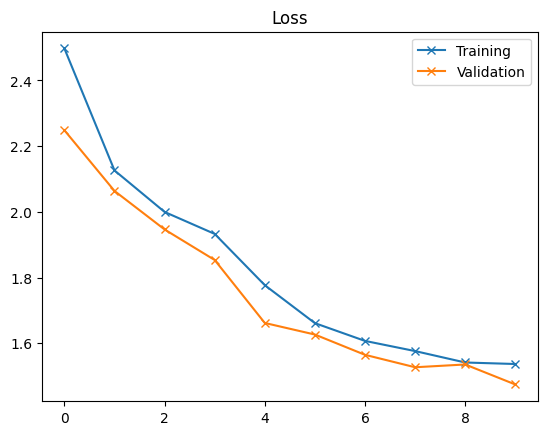

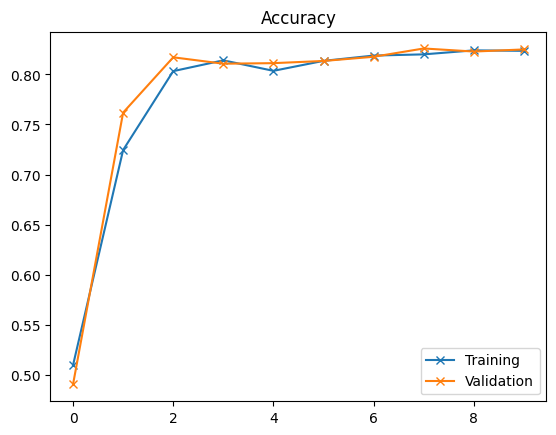

In [83]:
# Plot the loss and mectricies
log_file = f"{model_path[:-3]}_log.csv"

epoch_list, acc_list, loss_list, val_acc_list, val_loss_list = extract_metrics_from_log(model_path)

plt.plot(epoch_list, loss_list, marker="x", label="Training")
plt.plot(epoch_list, val_loss_list, marker="x", label="Validation")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(epoch_list, acc_list, marker="x", label="Training")
plt.plot(epoch_list, val_acc_list, marker="x", label="Validation")
plt.title("Accuracy")
plt.legend()
plt.show()


# Model inference

In [84]:
# Run inference on the validation set
# Get the validation image paths
test_file_dict = {file_name[:-4]: os.path.join(validation_img_folder, file_name)
                  for file_name in os.listdir(validation_img_folder)
                  if file_name.endswith(".tif")}
print(test_file_dict.keys())
print(test_file_dict["field_boundaries_412_206_1"])
# Prepare a validation image for inference
test_array = read_raster(test_file_dict["field_boundaries_412_206_1"])[0]  # Only return the array
test_array = np.transpose(test_array, (1, 2, 0))  # Tensorflow expects the channels to be last
test_array = test_array.reshape((1, 256, 256, 3)).astype(np.float32)  # Array expected shape (1, 256, 256, 3) (batch, rows, colums, channels)
print(test_array.shape)
# Load the model
trained_model = load_model(model_path)
print("Model summary", trained_model.summary())

# Run inference
results = trained_model.predict(test_array, verbose=0)
results *= 100 # Convert to percentage
results = results.astype('uint8') 
results = results.reshape((256, 256))
print("Results shape", results.shape)

dict_keys(['field_boundaries_0_0', 'field_boundaries_0_1030_1', 'field_boundaries_0_206_1', 'field_boundaries_0_412_1', 'field_boundaries_0_412_2', 'field_boundaries_0_412_3', 'field_boundaries_206_1030_1', 'field_boundaries_206_206_2', 'field_boundaries_206_412', 'field_boundaries_206_618_2', 'field_boundaries_206_618_3', 'field_boundaries_206_824_3', 'field_boundaries_412_0_1', 'field_boundaries_412_206_1', 'field_boundaries_412_824', 'field_boundaries_412_824_2', 'field_boundaries_618_0_1', 'field_boundaries_618_1030', 'field_boundaries_618_1030_3', 'field_boundaries_618_412_1', 'field_boundaries_618_618_1', 'field_boundaries_618_618_3', 'field_boundaries_618_824_1', 'field_boundaries_618_824_2'])
/app/notebooks/data/validation/image/field_boundaries_412_206_1.tif
(1, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to         

In [85]:
# Basic post processing
results_post_process = deepcopy(results)
# Threshold probabilites
results_post_process = np.where(results_post_process >= 70, 255, 0).astype(np.uint8)

# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(results_post_process)
print("num_labels", num_labels)

# Create image with fields overlay
results_poly = deepcopy((test_array[0] * 255).astype(np.uint8))
for label in range(num_labels)[1:]:
    for n in range(3):
        results_poly[:, :, n][labels == label] = random.randint(1, 255)

# Create image with field boundaries overlay
thresh = np.where(results_post_process == 255, 1, 0).astype(np.uint8)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = (deepcopy(test_array) * 255).astype(np.uint8)
# Draw the outlines on the image
cv2.drawContours(img[0][:, :, 0], contours, -1, (255), 1)
cv2.drawContours(img[0][:, :, 1], contours, -1, (255), 1)
cv2.drawContours(img[0][:, :, 2], contours, -1, (255), 1)


num_labels 119


array([[190, 255, 255, ..., 255,   0,   0],
       [178, 255, 202, ...,  16, 255, 255],
       [171, 255, 187, ...,  35,  36, 255],
       ...,
       [215, 255, 205, ..., 157, 150, 145],
       [215, 212, 255, ..., 159, 150, 157],
       [212, 212, 255, ..., 148, 149, 148]], dtype=uint8)

# Display results

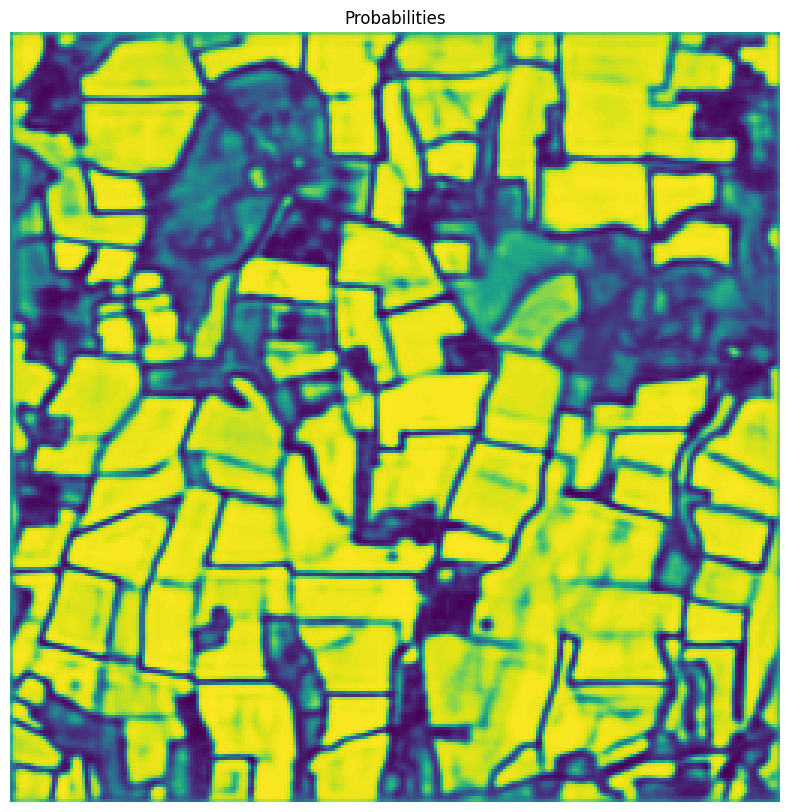

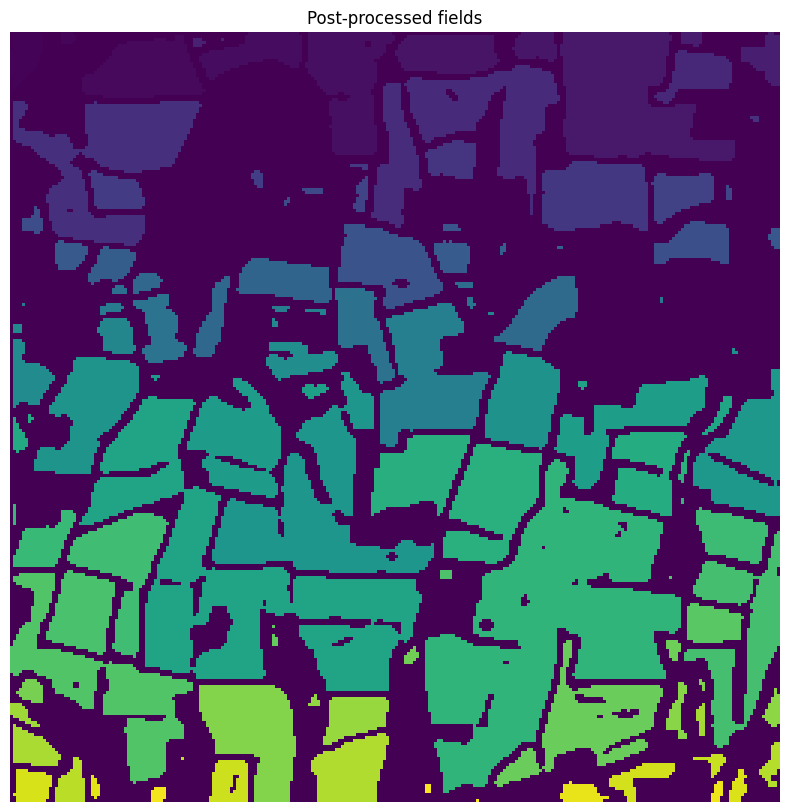

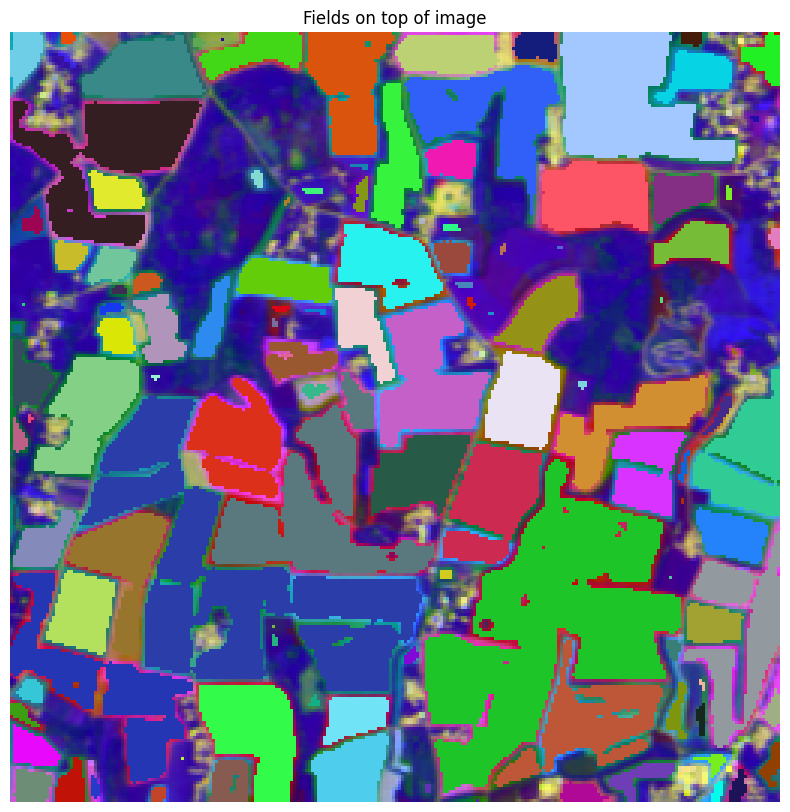

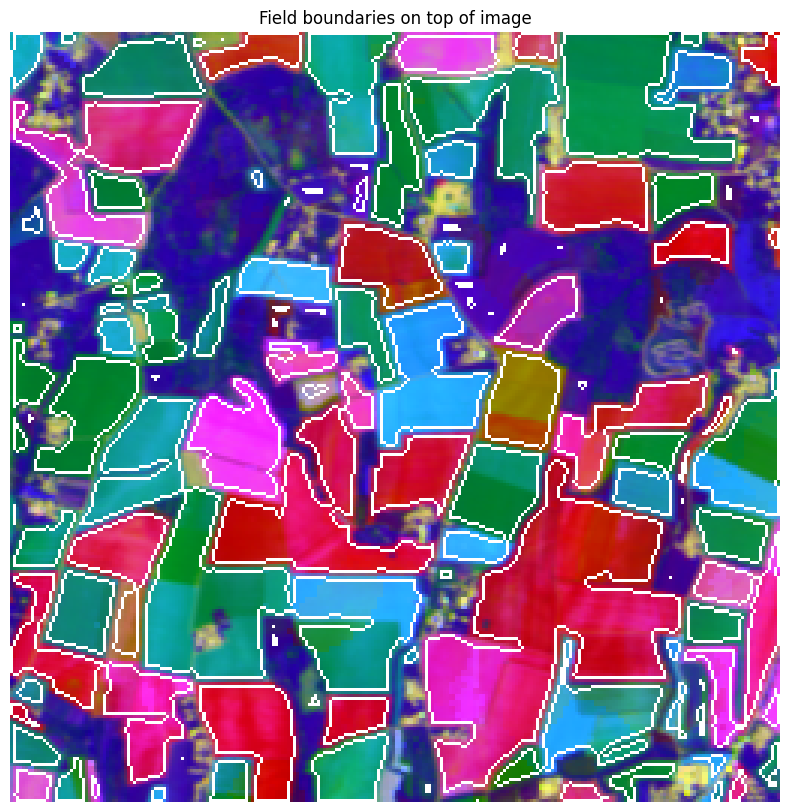

In [86]:
# Display results
plt.figure(figsize = (10,10))
plt.title("Probabilities")
plt.imshow(results)
plt.axis('off')
plt.show()

plt.figure(figsize = (10,10))
plt.title("Post-processed fields")
plt.imshow(labels)
plt.axis('off')
plt.show()

plt.figure(figsize = (10,10))
plt.title("Fields on top of image")
plt.imshow(results_poly)
plt.axis('off')
plt.show()

plt.figure(figsize = (10,10))
plt.title("Field boundaries on top of image")
plt.imshow(img[0])
plt.axis('off')
plt.show()